<a href="https://colab.research.google.com/github/Qjizhi/CSE659/blob/main/Dreambooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the implementation of [Dreambooth](https://dreambooth.github.io/) using diffusers library. This notebook is base on the docs [DreamBooth](https://huggingface.co/docs/diffusers/v0.30.2/en/training/dreambooth#dreambooth) of diffusers.

Paper: DreamBooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation.   
Link: https://arxiv.org/abs/2208.12242.  
Name: Feng Qiao  

![](https://dreambooth.github.io/DreamBooth_files/teaser_static.jpg)

In [1]:
!git clone https://github.com/huggingface/diffusers
%cd diffusers
!pip install .

Cloning into 'diffusers'...
remote: Enumerating objects: 71040, done.
remote: Counting objects: 100% (598/598), done.
remote: Compressing objects: 100% (336/336), done.
remote: Total 71040 (delta 357), reused 368 (delta 204), pack-reused 70442 (from 1)
Receiving objects: 100% (71040/71040), 50.03 MiB | 9.32 MiB/s, done.
Resolving deltas: 100% (52434/52434), done.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.31.0.dev0-py3-none-any.whl size=2772781 sha256=507076061f57d2d7aa3015f47e4e39bb5f53b4774be65e4445fc0d2f5c721bf2
  Stored in directory: /tmp/pip-ephem-wheel-cache-gvibp1nf/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers


In [3]:
%cd examples/dreambooth
!pip install -r requirements.txt

[Errno 2] No such file or directory: 'examples/dreambooth'
/content/diffusers/examples/dreambooth
  Using cached ftfy-6.2.3-py3-none-any.whl.metadata (7.8 kB)
  Using cached peft-0.7.0-py3-none-any.whl.metadata (25 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.1 MB/s eta 0:00:00


In [13]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 7.2 MB/s eta 0:00:00


In [4]:
# !pip install huggingface_hub
# !huggingface-cli login
from huggingface_hub import notebook_login
notebook_login()

In [8]:
# Upload traning progress to wandb
!pip install wandb

import wandb
wandb.login()

  Using cached wandb-0.18.1-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
  Using cached sentry_sdk-2.14.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached setproctitle-1.3.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
# Download training datases
!git clone https://github.com/google/dreambooth.git

Cloning into 'dreambooth'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 5), reused 1 (delta 1), pack-reused 206 (from 1)
Receiving objects: 100% (212/212), 106.84 MiB | 18.46 MiB/s, done.
Resolving deltas: 100% (10/10), done.


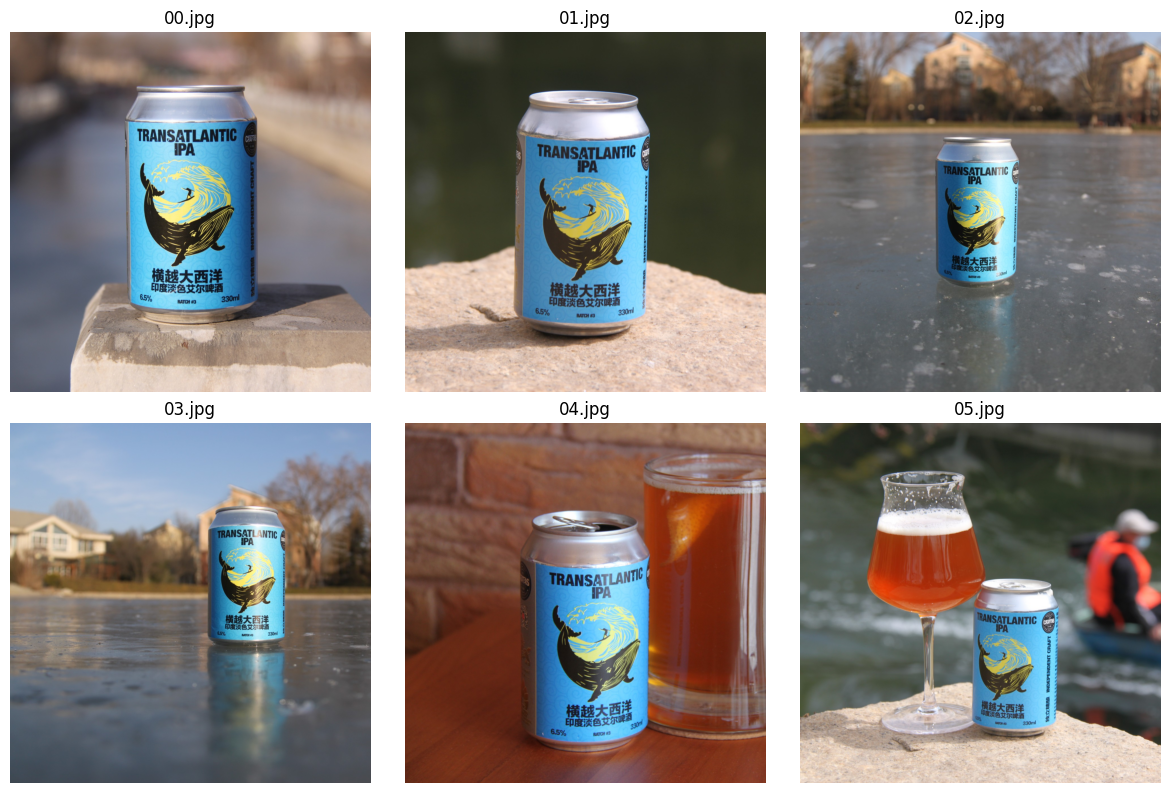

In [10]:
# Display training images
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the directory containing images
folder_path = './dreambooth/dataset/can'  # Change this to your folder path

# Get the list of image files in the folder
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png', 'gif'))])

# Select up to 6 images
images_to_display = image_files[:6]

# Create a subplot for displaying images
plt.figure(figsize=(12, 8))

for i, image_file in enumerate(images_to_display):
    img = mpimg.imread(os.path.join(folder_path, image_file))

    plt.subplot(2, 3, i + 1)  # Create a 2x3 grid
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(image_file)

plt.tight_layout()
plt.show()

In [11]:
# Check GPU memory
!nvidia-smi --query-gpu=memory.used,memory.free,memory.total --format=csv
# use default to train on 16gb GPU
!accelerate config default

memory.used [MiB], memory.free [MiB], memory.total [MiB]
0 MiB, 15101 MiB, 15360 MiB
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [14]:
# Set environment variables
os.environ["MODEL_NAME"] = "runwayml/stable-diffusion-v1-5"
os.environ["INSTANCE_DIR"] = "./dreambooth/dataset/can"
os.environ["OUTPUT_DIR"] = "output"

# Run the training script
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path={os.environ['MODEL_NAME']}  \
  --instance_data_dir={os.environ['INSTANCE_DIR']} \
  --output_dir={os.environ['OUTPUT_DIR']} \
  --instance_prompt="a photo of can on the bed" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=400 \
  --push_to_hub \
  --mixed_precision="bf16" \
  --report_to wandb \
  --use_8bit_adam


2024-09-23 21:05:50.938762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 21:05:51.028328: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 21:05:51.037203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 21:05:51.060534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-23 21:05:53.173975: W tensorflow/comp

model_index.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/915 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

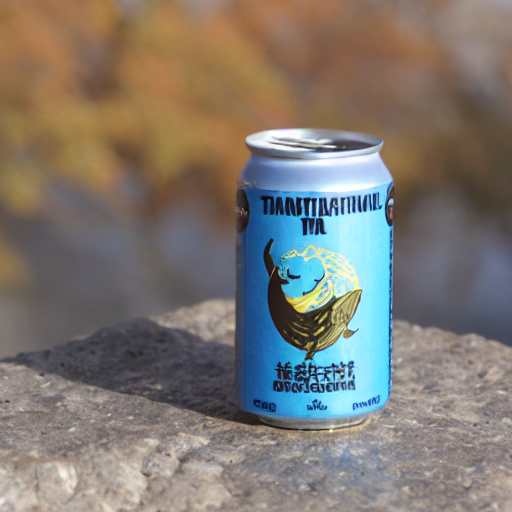

In [18]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained("FQiao/DreamboothCan", torch_dtype=torch.float16).to("cuda")
prompt = "a photo of can on the desk"
image = pipeline(prompt).images[0]
image
# It's worth noting that the text is not well reconstructed.
# And it seems the prompt doesn't work, I think this is because the training dataset is not diverse, 3 of 6 images are standing on rocks.